# Duplicate detection - step 1: find the potential duplicates

This notebook runs the first part of the duplicate detection algorithm on a dataframe with the following columns:

- `archiveType`       (used for duplicate detection algorithm)
- `dataSetName`
- `datasetId`
- `geo_meanElev`      (used for duplicate detection algorithm)
- `geo_meanLat`       (used for duplicate detection algorithm)
- `geo_meanLon`       (used for duplicate detection algorithm)
- `geo_siteName`      (used for duplicate detection algorithm)
- `interpretation_direction`
- `interpretation_seasonality`
- `interpretation_variable`
- `interpretation_variableDetails`
- `originalDataURL`
- `originalDatabase`
- `paleoData_notes`
- `paleoData_proxy`   (used for duplicate detection algorithm)
- `paleoData_units`
- `paleoData_values`  (used for duplicate detection algorithm, test for correlation, RMSE, correlation of 1st difference, RMSE of 1st difference)
- `paleoData_variableName`
- `year`              (used for duplicate detection algorithm)
- `yearUnits`

The key function for duplicate detection is `find_duplicates` in `f_duplicate_search.py`

The output is saved as csvs in the directory `data/DATABASENAME/dup_detection`, which are used again for step 2 (`dup_decisions.py`):
- `pot_dup_correlations_DATABASENAME.csv`
   - matrix of correlations between each pair      
- `pot_dup_distances_km_DATABASENAME.csv`
   - matrix of distances between each pair 
- `pot_dup_IDs_DATABASENAME.csv`
   - saves the IDs of each pair
- `pot_dup_indices_DATABASENAME.csv`
   - saves the dataframe indices of each pair

Summary figures of the potential duplicate pairs are created and the plots are saved in the same directory, following:
duplicatenumber_ID1_ID2_index1_index2.jpg

Updates:
- 06/11/2025 by LL: Tidied up and updated for DoD2k v2.0
- 27/11/2024 by LL: Fixed a bug in find_duplicates (in f_duplicate_search) and relaxed site criteria.

27/9/2024 created by LL

Author: Lucie J. Luecke

## Set up working environment

Make sure the repo_root is added correctly, it should be: your_root_dir/dod2k
This should be the working directory throughout this notebook (and all other notebooks).

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
from pathlib import Path

# Add parent directory to path (works from any notebook in notebooks/)
# the repo_root should be the parent directory of the notebooks folder
current_dir = Path().resolve()
# Determine repo root
if current_dir.name == 'dod2k': repo_root = current_dir
elif current_dir.parent.name == 'dod2k': repo_root = current_dir.parent
else: raise Exception('Please review the repo root structure (see first cell).')

# Update cwd and path only if needed
if os.getcwd() != str(repo_root):
    os.chdir(repo_root)
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

print(f"Repo root: {repo_root}")
if str(os.getcwd())==str(repo_root):
    print(f"Working directory matches repo root. ")

Repo root: /home/jupyter-lluecke/dod2k_v2.0/dod2k
Working directory matches repo root. 


In [2]:
import pandas as pd
import numpy as np

from dod2k_utilities import ut_functions as utf # contains utility functions
from dod2k_utilities import ut_duplicate_search as dup # contains utility functions

## Load dataset

Define the dataset which needs to be screened for duplicates. Input files for the duplicate detection mechanism need to be compact dataframes (`pandas` dataframes with standardised columns and entry formatting). 

The function `load_compact_dataframe_from_csv` loads the dataframe from a `csv` file from `data\DB\`, with `DB` the name of the database. The database name (`db_name`) can be 
- `pages2k`
- `ch2k`
- `iso2k`
- `sisal`
- `fe23`

for the individual databases, or 

- `all_merged`

to load the merged database of all individual databases, or can be any user defined compact dataframe.

In [3]:
# load dataframe
db_name='all_merged' 
# db_name = 'dup_test'
# db_name='ch2k' 
df = utf.load_compact_dataframe_from_csv(db_name)

print(df.info())
df.name = db_name


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5320 entries, 0 to 5319
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   archiveType                    5320 non-null   object 
 1   dataSetName                    5320 non-null   object 
 2   datasetId                      5320 non-null   object 
 3   geo_meanElev                   5221 non-null   float32
 4   geo_meanLat                    5320 non-null   float32
 5   geo_meanLon                    5320 non-null   float32
 6   geo_siteName                   5320 non-null   object 
 7   interpretation_direction       5320 non-null   object 
 8   interpretation_seasonality     5320 non-null   object 
 9   interpretation_variable        5320 non-null   object 
 10  interpretation_variableDetail  5320 non-null   object 
 11  originalDataURL                5320 non-null   object 
 12  originalDatabase               5320 non-null   o

# Duplicate Detection

### Find duplicates

Now run the first part of the duplicate detection algorithm, which goes through each candidate pair and evaluates the pairs for the following criteria:

- **metadata criteria**:
  - archive types (`archiveType`) must be identical
  - proxy types (`paleoData_proxy`) must be identical
- **geographical criteria**:
  - elevation (`geo_meanElev`) similar, within defined tolerance (use kwarg `elevation_tolerance`, defaults to 0)
  - latitude and longtitude (`geo_meanLat` and `geo_meanLon`) similar, within defined tolerance in km (use kwarg `dist_tolerance_km`, defaults to 8 km)
- **overlap criterion**:
  - time must overlap for at least $n$ points (use kwarg `n_points_thresh` to modify, defaults to $n=10$) unless at least one of the record is shorter than `n_points_thresh` 
- **site criterion**:
  - there must be some overlap in the site name (`geo_siteName`)
- **correlation criteria**:
  - correlation between the overlapping period must be greater than defined threshold (use `corr_thresh` to modify, defaults to 0.9) or correlation of first difference must be greater than defined threshold (use `corr_diff_thresh` to modify, defaults to 0.9)
  - RMSE of overlapping period must be smaller than defined threshold (use `rmse_thresh` to modify, defaults to 0.1) or RMSE of first difference must be smaller than defined threshold (use `rmse_diff_thresh` to modify, defaults to 0.1)
- **URL criterion**:
  - URLs (`originalDataURL`) must be identical if both records originate from the same database (`originalDatabase` must be identical)


-----

 **A potential duplicate candidate pair is flagged, if all of these criteria are satisfied OR the correlation between the candidates is particularly high (>0.98), while there is sufficient overlap (as defined by the overlap criterion).**

 ----

The output for a database named `DB` is saved under `data/DB/dup_detection/dup_detection_candidates_DB.csv`.
 

In [4]:
## run the find duplicate algorithm
dup.find_duplicates_optimized(df, n_points_thresh=10)


all_merged
Start duplicate search:
checking parameters:
proxy archive                  :  must match     
proxy type                     :  must match     
distance (km)                  < 8               
elevation                      :  must match     
time overlap                   > 10              
correlation                    > 0.9             
RMSE                           < 0.1             
1st difference rmse            < 0.1             
correlation of 1st difference  > 0.9             
Start duplicate search
Progress: 0/5320
--> Found potential duplicate: 0: pages2k_0&4408: iso2k_296 (n_potential_duplicates=1)
--> Found potential duplicate: 0: pages2k_0&4409: iso2k_298 (n_potential_duplicates=2)
--> Found potential duplicate: 0: pages2k_0&4410: iso2k_299 (n_potential_duplicates=3)
--> Found potential duplicate: 2: pages2k_6&3037: fe23_northamerica_usa_az555 (n_potential_duplicates=4)
Progress: 10/5320
--> Found potential duplicate: 17: pages2k_50&1587: fe23_northamerica_

/home/jupyter-mnevans/.conda/envs/cfr-env/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/jupyter-mnevans/.conda/envs/cfr-env/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Progress: 4440/5320
Progress: 4450/5320
--> Found potential duplicate: 4456: iso2k_505&4482: iso2k_579 (n_potential_duplicates=399)
Progress: 4460/5320
--> Found potential duplicate: 4468: iso2k_533&4843: sisal_115.0_69 (n_potential_duplicates=400)
Progress: 4470/5320
--> Found potential duplicate: 4471: iso2k_546&4473: iso2k_549 (n_potential_duplicates=401)
--> Found potential duplicate: 4472: iso2k_547&4474: iso2k_550 (n_potential_duplicates=402)
Progress: 4480/5320
Progress: 4490/5320
Progress: 4500/5320
--> Found potential duplicate: 4501: iso2k_702&4502: iso2k_705 (n_potential_duplicates=403)
Progress: 4510/5320
--> Found potential duplicate: 4514: iso2k_772&4515: iso2k_775 (n_potential_duplicates=404)
--> Found potential duplicate: 4518: iso2k_786&4519: iso2k_788 (n_potential_duplicates=405)
Progress: 4520/5320
--> Found potential duplicate: 4521: iso2k_806&4522: iso2k_811 (n_potential_duplicates=406)
Progress: 4530/5320
--> Found potential duplicate: 4539: iso2k_873&5088: sisal_

## Plot duplicate candidate pairs

*OPTIONAL*: plot the duplicate candidate pairs, which were flagged by the duplicate detection algorithm. 
The function `plot_duplicates` loads the flagged candidate pairs for a database named `DB` from csv (`data/DB/dup_detection/dup_detection_candidates_DB.csv`) and produces summary figures of the potential duplicates, which are saved in the directory `figs/DB/dup_detection/`.

**Note that the same summary figures are being used for the duplicate decision process (`dup_decisions.ipynb`).**

> 0/429,pages2k_0,iso2k_296,0.0,0.9999999995947852


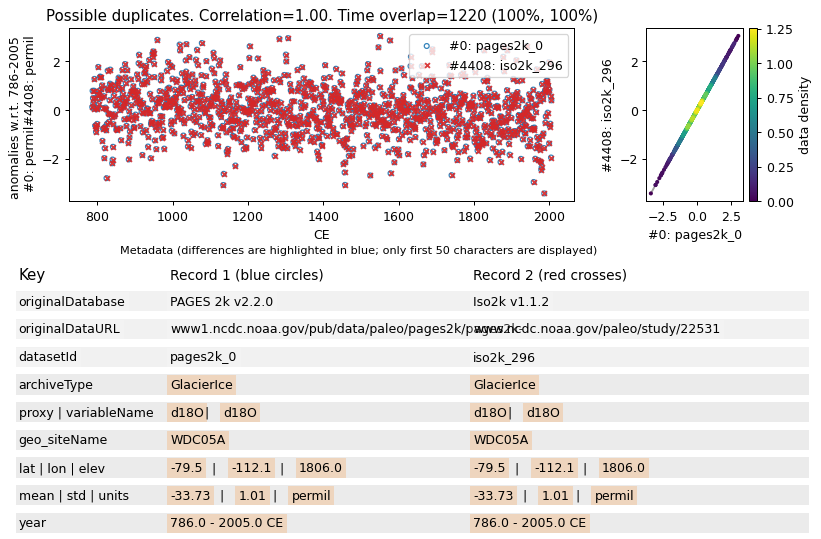

TypeError: save_fig() got an unexpected keyword argument 'form'

In [5]:
dup.plot_duplicates(df, save_figures=True)

In [ ]:
fn = utf.find(f'dup_detection_candidates_{df.name}.csv',  f'data/{df.name}/dup_detection')

In [ ]:
if fn != []:
    print('----------------------------------------------------')
    print('Sucessfully finished the duplicate detection process!'.upper())
    print('----------------------------------------------------')
    print('Saved the detection output file in:')
    print()
    print('%s.'%', '.join(fn))
    print()
    print('You are now able to proceed to the next notebook: dup_decision.ipynb')
else:
    print('Final output file is missing.')
    print()
    print('Please re-run the notebook to complete duplicate detection process.')